In [3]:
import numpy as np
import scipy as scp
from scipy import constants as const
import matplotlib.pyplot as plt
from scipy import integrate
from bayes_opt.bayesian_optimization import BayesianOptimization

In [4]:
def Bfield(z,i,n): # return in Gauss
    r = 10.16e-2
    d = 7.1976e-2
    return abs(1/((z*1e-3-d)**2+r**2)**(3/2)-1/((z*1e-3+d)**2+r**2)**(3/2))*const.mu_0/2*r**2*i*n*1e4

def Bfield_twin(z,i,n,r1,r2): # return in Gauss
    r1s = r1*1e-3
    r2s = r2*1e-3
    d = 7.1976e-2
    return (abs(1/((z*1e-3-d)**2+r1s**2)**(3/2)-1/((z*1e-3+d)**2+r1s**2)**(3/2))*const.mu_0/2*r1s**2*i*n*1e4)+(abs(1/((z*1e-3-d)**2+r2s**2)**(3/2)-1/((z*1e-3+d)**2+r2s**2)**(3/2))*const.mu_0/2*r2s**2*i*n*1e4)

def B_truth(z):
    return 2*abs(z)

def temperature(i,n):
    c = 0.385
    density = 8.96e-3 #g/mm^3
    A = 0.3**2*np.pi
    
    def heat(ii,nn):
        def resistance(ii,nn):
            return 1.68e-8*101.6*2*nn/0.326*1e3

        r = resistance(i,n)
        return i**2*r
    
    return heat(i,n)/(c*density*A*101.6*np.pi*2*n)

In [5]:
temperature(5,1000)

0.4204561374688678

In [8]:
I = 4.3
n = 500
I1 = 3.0
n1 = 200

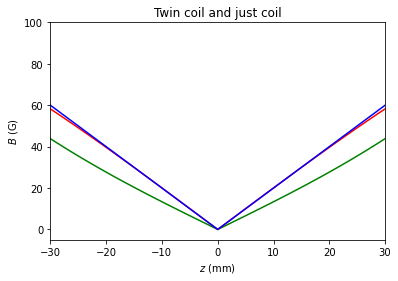

In [9]:
x = np.linspace(-500,500,2001)
xplus = np.linspace(0,50,1001)
xminus = np.linspace(-50,0,1001)


fig,ax = plt.subplots(1,1)

# ax.plot(xplus,Bfield(xplus,4,600),'r')
# ax.plot(xminus,Bfield(xminus,4,600),'r')
ax.plot(x,Bfield_twin(x,I1,n1,45,100),'g')
ax.plot(x,Bfield(x,I,n),'r')
ax.plot(x,B_truth(x),'b')
ax.set_xlabel('$z\ \mathrm{(mm)}$')
ax.set_ylabel('$B\ \mathrm{(G)}$')
ax.set_title(f'Twin coil and just coil')
ax.set_xlim(-30,30)
ax.set_ylim(-5,100)
plt.show()
fig.savefig('D:/MOT chamber design/coil with truth value.png')

In [6]:
def Error_func(I,n):
    def temp_func(z,ii,nn):
        return abs(Bfield(z,ii,nn)-B_truth(z))
    
    return integrate.quad(temp_func,-30,30,args=(I,n))[0]*-1

In [7]:
def Error_func_2(I,n,r1,r2):
    def temp_func(z,ii,nn,r11,r22):
        return abs(Bfield_twin(z,ii,nn,r11,r22)-B_truth(z))
    
    return integrate.quad(temp_func,-30,30,args=(I,n,r1,r2))[0]*-1

In [8]:
Error_func_2(4,200,40,70)

-98.24501063111708

In [9]:
pbounds1 = {'I':(0.1,5),'n':(100,1000)}
pbounds2 = {'I':(0.1,5),'n':(1,200),'r1':(30,100),'r2':(100,200)}

In [10]:
optimizer = BayesianOptimization(Error_func,
                                                       pbounds=pbounds1,
                                                       verbose=2,
                                                       random_state=1
                                                       )
optimizer2 = BayesianOptimization(Error_func_2,
                                                       pbounds=pbounds2,
                                                       verbose=2,
                                                       random_state=1
                                                       )

In [11]:
optimizer.maximize(init_points=50, n_iter=200,)

|   iter    |  target   |     I     |     n     |
-------------------------------------------------
|  1        | -258.3    |  2.143    |  748.3    |
|  2        | -1.752e+0 |  0.1006   |  372.1    |
|  3        | -1.608e+0 |  0.8191   |  183.1    |
|  4        | -1.266e+0 |  1.013    |  411.0    |
|  5        | -265.6    |  2.044    |  584.9    |
|  6        | -181.1    |  2.154    |  716.7    |
|  7        | -541.2    |  1.102    |  890.3    |
|  8        | -1.589e+0 |  0.2342   |  703.4    |
|  9        | -140.8    |  2.145    |  602.8    |
|  10       | -1.519e+0 |  0.7879   |  278.3    |
|  11       | -3.216e+0 |  4.024    |  971.4    |
|  12       | -282.1    |  1.636    |  723.1    |
|  13       | -3.304e+0 |  4.394    |  905.1    |
|  14       | -1.71e+03 |  0.5167   |  135.1    |
|  15       | -735.0    |  0.9322   |  890.3    |
|  16       | -1.442e+0 |  0.5819   |  479.0    |
|  17       | -1.767e+0 |  4.794    |  579.8    |
|  18       | -85.75    |  3.49     |  384.0    |


In [12]:
optimizer2.maximize(init_points=50,n_iter=200)

|   iter    |  target   |     I     |     n     |    r1     |    r2     |
-------------------------------------------------------------------------
|  1        | -1.344e+0 |  2.143    |  144.3    |  30.01    |  130.2    |
|  2        | -1.772e+0 |  0.8191   |  19.38    |  43.04    |  134.6    |
|  3        | -1.446e+0 |  2.044    |  108.2    |  59.34    |  168.5    |
|  4        | -1.546e+0 |  1.102    |  175.7    |  31.92    |  167.0    |
|  5        | -1.364e+0 |  2.145    |  112.2    |  39.83    |  119.8    |
|  6        | -545.7    |  4.024    |  193.7    |  51.94    |  169.2    |
|  7        | -312.7    |  4.394    |  179.0    |  35.95    |  103.9    |
|  8        | -1.541e+0 |  0.9322   |  175.8    |  36.88    |  142.1    |
|  9        | -954.4    |  4.794    |  107.1    |  78.43    |  131.6    |
|  10       | -1.07e+03 |  3.464    |  167.1    |  31.28    |  175.0    |
|  11       | -641.0    |  4.945    |  149.9    |  49.63    |  178.9    |
|  12       | -1.719e+0 |  0.6058   | 

In [13]:
optimizer.max

{'target': -61.651995264187676,
 'params': {'I': 4.397818838432238, 'n': 318.4775907433924}}

In [14]:
optimizer2.max

{'target': -14.315943574211774,
 'params': {'I': 5.0, 'n': 200.0, 'r1': 90.09539720515635, 'r2': 100.0}}